#CNN on CIFR Assignment:

1.  Please visit this link to access the state-of-art DenseNet code for reference - DenseNet - cifar10 notebook link
2.  You need to create a copy of this and "retrain" this model to achieve 90+ test accuracy. 
3.  You cannot use Dense Layers (also called fully connected layers), or DropOut.
4.  You MUST use Image Augmentation Techniques.
5.  You cannot use an already trained model as a beginning points, you have to initilize as your own
6.  You cannot run the program for more than 300 Epochs, and it should be clear from your log, that you have only used 300 Epochs
7.  You cannot use test images for training the model.
8.  You cannot change the general architecture of DenseNet (which means you must use Dense Block, Transition and Output blocks as mentioned in the code)
9.  You are free to change Convolution types (e.g. from 3x3 normal convolution to Depthwise Separable, etc)
10. You cannot have more than 1 Million parameters in total
11. You are free to move the code from Keras to Tensorflow, Pytorch, MXNET etc. 
12. You can use any optimization algorithm you need. 
13. You can checkpoint your model and retrain the model from that checkpoint so that no need of training the model from first if you lost at any epoch while training. You can directly load that model and Train from that epoch. 

In [ ]:
# import keras
# from keras.datasets import cifar10
# from keras.models import Model, Sequential
# from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
# from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
# from keras.layers import Concatenate
# from keras.optimizers import Adam
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import Adam

In [ ]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf

In [ ]:
# Hyperparameters
batch_size = 128
num_classes = 10
epochs = 10
l = 40
num_filter = 12
compression = 0.5
dropout_rate = 0.2

In [ ]:
# Load CIFAR10 Data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
img_height, img_width, channel = X_train.shape[1],X_train.shape[2],X_train.shape[3]

# convert to one hot encoing 
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes) 

170500096/170498071 [==============================] - 6s 0us/step


In [ ]:
X_train.shape

(50000, 32, 32, 3)

In [ ]:
X_test.shape

(10000, 32, 32, 3)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

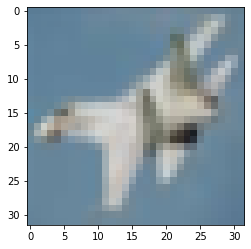

In [ ]:
from matplotlib import pyplot
pyplot.imshow(X_test[10])

In [ ]:
#https://github.com/moritzhambach/Image-Augmentation-in-Keras-CIFAR-10-/blob/master/CNN%20with%20Image%20Augmentation%20(CIFAR10).ipynb
datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
    #zoom_range=0.3
    )
datagen.fit(X_train)

In [ ]:
# Dense Block
def denseblock(input, num_filter = 12, dropout_rate = 0.0):
    global compression
    temp = input
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_3_3 = layers.Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
            Conv2D_3_3 = layers.Dropout(dropout_rate)(Conv2D_3_3)
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

## transition Blosck
def transition(input, num_filter = 12, dropout_rate = 0.0):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
         Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

#output layer
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
    flat = layers.Flatten()(AvgPooling)
    output = layers.Dense(num_classes, activation='softmax')(flat)
    return output

In [ ]:
num_filter = 32
dropout_rate = 0.0
l = 12
input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = layers.Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = transition(First_Block, num_filter, dropout_rate)

Second_Block = denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = transition(Second_Block, num_filter, dropout_rate)

Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, num_filter, dropout_rate)

Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

# model for DenseNet
model = Model(inputs=[input], outputs=[output])

In [ ]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_52 (Conv2D)              (None, 32, 32, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_52 (BatchNo (None, 32, 32, 32)   128         conv2d_52[0][0]                  
__________________________________________________________________________________________________
activation_52 (Activation)      (None, 32, 32, 32)   0           batch_normalization_52[0][0]     
_______________________________________________________________________________________

In [ ]:
from google.colab import drive
drive.mount('gdrive',force_remount=True)

Mounted at gdrive


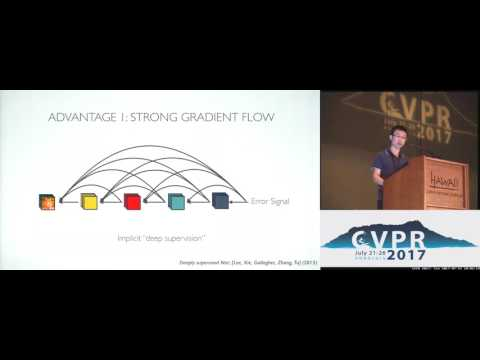

In [ ]:
#https://arxiv.org/pdf/1608.06993.pdf
from IPython.display import IFrame, YouTubeVideo
YouTubeVideo(id='-W6y8xnd--U', width=600)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
def changeLearningRate(epochs,learning_rate):
  if epochs<50:
    learning_rate=0.01
    return learning_rate
    
  elif epochs<75:
    learning_rate=0.001
    return learning_rate
  else:
    learning_rate=0.0001
    return learning_rate



lrschedule = LearningRateScheduler(changeLearningRate,verbose=1)

In [ ]:
filepath="model_save/weights-{epoch:02d}-{val_accuracy:.4f}.h5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',  verbose=1, save_best_only=True, mode='auto')

In [ ]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.01),
              metrics=['accuracy'])

In [ ]:
#optimizer
#optimizer = tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,name='Adam')
#model.compile(optimizer=optimizer, loss='categorical_crossentropy',metrics=[tf.keras.metrics.Accuracy(name='acc',dtype=None)])


In [ ]:
# train with image augmentation
history=model.fit_generator(datagen.flow(X_train, y_train, batch_size=128),
                    steps_per_epoch = len(X_train) / 128, epochs=100, validation_data=(X_test, y_test),callbacks=[lrschedule,checkpoint ])

Instructions for updating:
Please use Model.fit, which supports generators.

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
Epoch 1/100
391/390 [==============================] - ETA: 0s - loss: 1.9246 - accuracy: 0.3113
Epoch 00001: val_accuracy improved from -inf to 0.24130, saving model to model_save/weights-01-0.2413.h5
391/390 [==============================] - 48s 124ms/step - loss: 1.9246 - accuracy: 0.3113 - val_loss: 2.3125 - val_accuracy: 0.2413

Epoch 00002: LearningRateScheduler reducing learning rate to 0.01.
Epoch 2/100
391/390 [==============================] - ETA: 0s - loss: 1.4385 - accuracy: 0.4775
Epoch 00002: val_accuracy improved from 0.24130 to 0.42790, saving model to model_save/weights-02-0.4279.h5
391/390 [==============================] - 46s 118ms/step - loss: 1.4385 - accuracy: 0.4775 - val_loss: 1.8228 - val_accuracy: 0.4279

Epoch 00003: LearningRateScheduler reducing learning rate to 0.01.
Epoch 3/100
391/390 [========================

#Obsevation
#####1)In this assigment we are classifying images of cifar dataset.
#####2) we have 10 classes in the dataset.
#####4) we have used image augmentation .
#####5) created DenseNet architecture  and trained the model ,got accuracy of .98 on train and 0.91 on test data

In [1]:
from tabulate import tabulate
import pandas as pd
weather_data = [("Model", 'DenseNet', 0.9801,0.9099),
               ]
df = pd.DataFrame(weather_data, columns=['Model', 'Model architecture', 'Train accuracy','Test accuracy'])


#Ref: https://pypi.org/project/tabulate/
print(tabulate(df, headers='keys', tablefmt='github'))

|    | Model   | Model architecture   |   Train accuracy |   Test accuracy |
|----|---------|----------------------|------------------|-----------------|
|  0 | Model   | DenseNet             |           0.9801 |          0.9099 |
